In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Part 1: Transfer Learning

In [2]:
# Utilize CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mean = np.array([0.485, 0.456, 0.496])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [4]:
# Import data
data_dir = "datasets/animals"
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in sets}

dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=0)
             for x in sets}

In [5]:
# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
print(dataset_sizes)

{'train': 150, 'val': 60}


In [6]:
# Get class names
class_names = image_datasets['train'].classes
print(class_names)

['bear', 'gorilla', 'other']


In [7]:
def train_model(mode, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in sets:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluation mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # trach history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} /t Loss: {epoch_loss:.4f} /t Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

# Give the model a new FC layer with number of classes in our case
model.fc = nn.Linear(num_ftrs, len(class_names))
model.to(device)  # Use CUDA if available

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Scheduler: for every 7 epochs, multiply the LR by gamma (0.1)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train /t Loss: 1.1248 /t Acc: 0.3800
val /t Loss: 0.9991 /t Acc: 0.4833

Epoch 2/10
----------
train /t Loss: 1.0145 /t Acc: 0.5133
val /t Loss: 0.8427 /t Acc: 0.6500

Epoch 3/10
----------
train /t Loss: 0.9246 /t Acc: 0.5733
val /t Loss: 0.8087 /t Acc: 0.6833

Epoch 4/10
----------
train /t Loss: 0.8427 /t Acc: 0.7133
val /t Loss: 0.6586 /t Acc: 0.7667

Epoch 5/10
----------
train /t Loss: 0.8146 /t Acc: 0.6867
val /t Loss: 0.5993 /t Acc: 0.8500

Epoch 6/10
----------
train /t Loss: 0.8029 /t Acc: 0.6533
val /t Loss: 0.6160 /t Acc: 0.8000

Epoch 7/10
----------
train /t Loss: 0.7305 /t Acc: 0.7600
val /t Loss: 0.5442 /t Acc: 0.8333

Epoch 8/10
----------
train /t Loss: 0.7221 /t Acc: 0.7067
val /t Loss: 0.5671 /t Acc: 0.8333

Epoch 9/10
----------
train /t Loss: 0.6887 /t Acc: 0.7533
val /t Loss: 0.5420 /t Acc: 0.8333

Epoch 10/10
----------
train /t Loss: 0.6776 /t Acc: 0.7667
val /t Loss: 0.5442 /t Acc: 0.8500

Training complete in 0m 56s
Best val acc: 0.85000

### Part 2: Facebook DETR

In [11]:
import requests
from PIL import Image

In [12]:
# Load Facebook DETR model
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

Using cache found in C:\Users\Kevin/.cache\torch\hub\facebookresearch_detr_master


In [13]:
# Input image address
url = input()

https://c402277.ssl.cf1.rackcdn.com/photos/18330/images/hero_small/Mountain_Gorilla_Silverback_WW22557.jpg?1576515753


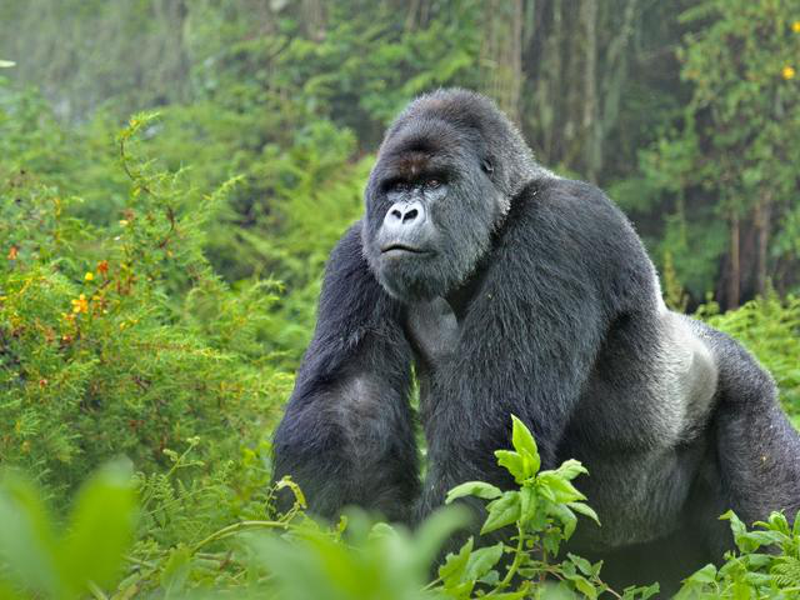

In [14]:
img = Image.open(requests.get(url, stream=True).raw).resize((800,600))
img

In [15]:
# Standard PyTorch input image normalization
transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [16]:
img_tensor = transform(img).unsqueeze(0).cuda()

In [19]:
with torch.no_grad():
    output = model(img_tensor)
    
output['pred']

RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 1024.00 MiB total capacity; 319.86 MiB already allocated; 6.11 MiB free; 326.00 MiB reserved in total by PyTorch)